In [2]:
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
from os.path import join

from skimage.measure import label
import scipy.io as io
import os

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from keras import Sequential
from keras.layers import Dense

from sklearn.datasets import make_classification

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
#Based on the dataset description from Bellet et al. 2018
#https://github.com/berenslab/uneye/blob/master/analysis%20scripts/Data.ipynb

def choose_class_data(cl):
    sets = ['dataset1', 'dataset2']
    classes = ['Fixations','Saccades']
    columns = ['Source', 'Duration', 'Amplitude', 'Peak_velocity', 'Class']
    df = pd.DataFrame(columns=columns)

    for i, folder in enumerate(sets):
        path = join('/Users/gelana/cs156/data', folder)
        print(path)

        train_x = np.loadtxt(path+'/'+'X_setA.csv', delimiter=',')   
        train_y = np.loadtxt(path+'/'+'Y_setA.csv', delimiter=',')
        train_l = np.loadtxt(path+'/'+'Labels_setA.csv', delimiter=',')


            #Choosing only the class and differentiating
        if cl=='Fixation':
            train_l = (train_l==0).astype(float) 
        else:
            train_l = (train_l==1).astype(float) 
            
        train_x_diff = np.diff(train_x,1)
        train_y_diff = np.diff(train_y,1)
        train_z = np.sqrt(train_x_diff**2+train_x_diff**2)*1000


        for row in range(train_l.shape[0]):
            train_label = label(train_l[row,:])


            for n in range(1, np.max(train_label)+1):
                cl_labels = np.argwhere(train_label==n)

                #Skipping the trace edges
                if ((cl_labels[0]==0) or (cl_labels[-1]==len(train_label)-1)):
                    continue
                else:
                    count = np.sum(train_label==n)
                    amp = np.sqrt((train_x[row,cl_labels[-1]]-train_x[row,cl_labels[0]])**2 + (train_y[row,cl_labels[-1]]-train_y[row,cl_labels[0]])**2)[0]
                    peak_vel = np.max(train_z[row,train_label[1:]==n])
                    df = df.append({'Source':sets[i],
                                   'Duration':count,
                                   'Amplitude':amp,
                                   'Peak_velocity':peak_vel,
                                   'Class': cl},ignore_index=True)


    #display(df)
    return df

In [31]:
#Getting the data
fixations = choose_class_data(cl='Fixation')
saccades = choose_class_data(cl='Saccade')

data = fixations.append(saccades, ignore_index=True)

/Users/gelana/cs156/data/dataset1


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


/Users/gelana/cs156/data/dataset2
/Users/gelana/cs156/data/dataset1
/Users/gelana/cs156/data/dataset2


In [5]:
data.head()

,Source,Duration,Amplitude,Peak_velocity,Class
0,dataset1,13,0.064367,17.811254,Fixation
1,dataset1,77,0.028720,14.249003,Fixation
2,dataset1,122,0.020308,10.686752,Fixation
3,dataset1,730,0.227050,21.373505,Fixation
4,dataset1,67,0.002519,17.811254,Fixation


/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


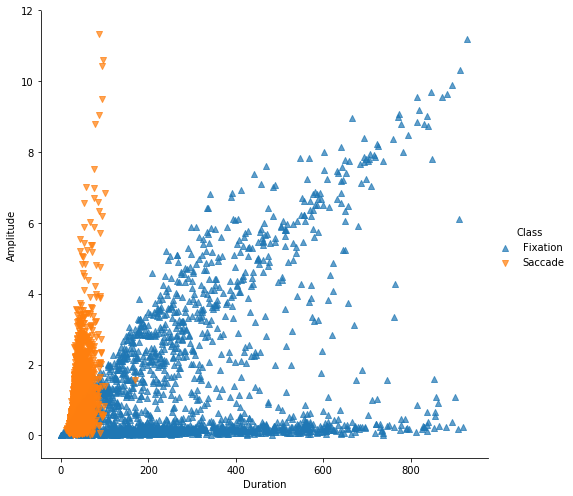

In [6]:
#Plotting
sns.FacetGrid(data, hue="Class", size=7, hue_kws={"marker": ["^", "v"]}).map(plt.scatter, "Duration", "Amplitude", alpha=0.7).add_legend()
plt.show()

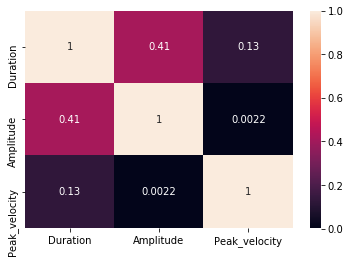

In [7]:
sns.heatmap(data.corr(), annot=True) #with duration

In [8]:
#Extracting the features vs labels
features = list(data.columns[1:4]) 
target = data.columns[4]

x = data.iloc[:,1:4]
y = data.iloc[:,4]

In [9]:
#Encoding
label_enc = LabelEncoder().fit(y)
y = label_enc.transform(y)
data['Encoding'] = y
print(label_enc.classes_)

['Fixation' 'Saccade']


In [10]:
#Separating
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=66)
st_sc = StandardScaler()
x_train = st_sc.fit_transform(x_train)
x_test = st_sc.transform(x_test)

In [11]:
#Classification through random forest
rf = RandomForestClassifier().fit(x_train, y_train)
rf_pred = rf.predict(x_test)

In [13]:
rf_cv_score = cross_val_score(rf, x, y, cv=10, scoring='roc_auc')
print("Confusion Matrix")
print(confusion_matrix(y_test, rf_pred))
print('\n')
print("Classification Report")
print(classification_report(y_test, rf_pred))
print('\n')
print("AUC Score")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

Confusion Matrix
[[ 688   33]
 [  43 1223]]


Classification Report
             precision    recall  f1-score   support

          0       0.94      0.95      0.95       721
          1       0.97      0.97      0.97      1266

avg / total       0.96      0.96      0.96      1987



AUC Score
Mean AUC Score - Random Forest:  0.9834534531144105


In [14]:
#Classification through a neural network 
neural = Sequential()
#First Hidden Layer
neural.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=3))
#Second  Hidden Layer
neural.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
neural.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
neural.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
neural.fit(x_train,y_train, batch_size=10, epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4034/4034 [==============================] - 1s 303us/step - loss: 0.6042 - acc: 0.7635 0s - loss: 0.6206 - acc: 0.749
Epoch 2/100
4034/4034 [==============================] - 0s 119us/step - loss: 0.3241 - acc: 0.8996
Epoch 3/100
4034/4034 [==============================] - 0s 116us/step - loss: 0.2398 - acc: 0.9197 0s - loss: 0.2394 - acc: 0.920
Epoch 4/100
4034/4034 [==============================] - 0s 119us/step - loss: 0.2161 - acc: 0.9229
Epoch 5/100
4034/4034 [==============================] - 0s 108us/step - loss: 0.2051 - acc: 0.9259
Epoch 6/100
4034/4034 [==============================] - 0s 118us/step - loss: 0.1977 - acc: 0.9266
Epoch 7/100
4034/4034 [==============================] - 0s 106us/step - loss: 0.1933 - acc: 0.9269
Epoch 8/100
4034/4034 [==============================] - 0s 104us/step - loss: 0.1887 - acc: 0.9269
Epoch 9/100
4034/4034 [==============================] - 0s 112us/step - loss: 0.1858 - ac

In [16]:
eval_model=neural.evaluate(x_train, y_train)
eval_model
neural_pred=neural.predict(x_test)
neural_pred =(neural_pred>0.5)


4034/4034 [==============================] - 0s 36us/step


In [17]:
print("Confusion Matrix")
print(confusion_matrix(y_test, neural_pred))
print('\n')
print("Classification Report")
print(classification_report(y_test, neural_pred))



Confusion Matrix
[[ 665   56]
 [  31 1235]]


Classification Report
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       721
          1       0.96      0.98      0.97      1266

avg / total       0.96      0.96      0.96      1987



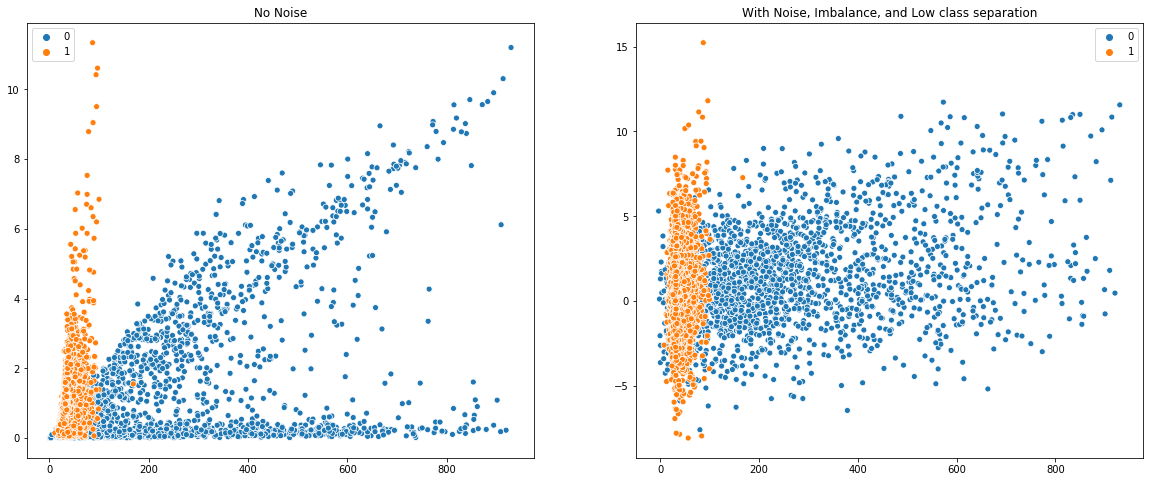

In [22]:
#Creating more data to add noise, imbalance, and complicate class separation
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.scatterplot(x.values[:,0],x.values[:,1],hue=y,ax=ax1);
ax1.set_title("No Noise")

f_data = make_classification(n_samples=6021, n_features=3, n_informative=3, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=0.1,
                   flip_y=0.1,weights=[0.85,0.15], random_state=17)
x_noise = f_data[0]
y_noise = f_data[1]
sns.scatterplot(2*x_noise[:,0]+x.values[:,0],2*x_noise[:,1]+x.values[:,1],hue=y,ax=ax2);
ax2.set_title("With Noise, Imbalance, and Low class separation");

plt.show()


In [23]:
columns = ['Source', 'Duration', 'Amplitude', 'Peak_velocity', 'Class']
f_df = pd.DataFrame(columns=columns)
for i in range(len(x)):
    f_dur = np.random.choice(x_noise[0])
    f_amp = np.sqrt(2*(np.random.choice(x_noise[1],1)-np.random.choice(x_noise[1],1))**2)[0]
    f_peak_vel = abs(np.random.choice(x_noise[2],1)).astype(float) 

    if y_noise[i]=="0":
        cl = 'Fixation'
    else:
        cl = 'Saccade'
        f_df = f_df.append({'Source':'Noisy',
                   'Duration':f_dur,
                   'Amplitude':f_amp,
                   'Peak_velocity':f_peak_vel,
                   'Class': cl},ignore_index=True)

In [24]:
synth_data = data.append(f_df, ignore_index=True)
f_features = list(synth_data.columns[1:4]) 
f_target = synth_data.columns[4]

f_x = synth_data.iloc[:,1:4]
f_y = synth_data.iloc[:,4]

label_enc2 = LabelEncoder().fit(f_y)
f_y = label_enc.transform(f_y)

f_x_train, f_x_test, f_y_train, f_y_test = train_test_split(f_x, f_y, test_size=0.33, random_state=66)
st_sc = StandardScaler()
f_x_train = st_sc.fit_transform(f_x_train)
f_x_test = st_sc.transform(f_x_test)

In [25]:
rf2 = RandomForestClassifier().fit(f_x_train, f_y_train)
rf_pred2 = rf2.predict(f_x_test)
rf_cv_score2 = cross_val_score(rf2, f_x, f_y, cv=10, scoring='roc_auc')

In [26]:
print("Confusion Matrix")
print(confusion_matrix(f_y_test, rf_pred2))
print('\n')
print("Classification Report")
print(classification_report(f_y_test, rf_pred2))
print('\n')
print("Mean AUC Score - Random Forest: ", rf_cv_score2.mean())
      

Confusion Matrix
[[ 688   43]
 [  29 3214]]


Classification Report
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       731
          1       0.99      0.99      0.99      3243

avg / total       0.98      0.98      0.98      3974



Mean AUC Score - Random Forest:  0.9909641557310591


In [27]:
#Classification through a neural network 
neural2 = Sequential()
#First Hidden Layer
neural2.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=3))
#Second  Hidden Layer
neural2.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
neural2.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
neural2.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [28]:
neural2.fit(f_x_train,f_y_train, batch_size=10, epochs=100)
eval_model2=neural2.evaluate(f_x_train, f_y_train)
eval_model2
neural_pred2=neural2.predict(f_x_test)
neural_pred2 =(neural_pred2>0.5)

Epoch 1/100
8068/8068 [==============================] - 2s 213us/step - loss: 0.3600 - acc: 0.9033
Epoch 2/100
8068/8068 [==============================] - 1s 145us/step - loss: 0.1227 - acc: 0.9623
Epoch 3/100
8068/8068 [==============================] - 1s 107us/step - loss: 0.1066 - acc: 0.9641
Epoch 4/100
8068/8068 [==============================] - 1s 110us/step - loss: 0.1018 - acc: 0.9652
Epoch 5/100
8068/8068 [==============================] - 1s 106us/step - loss: 0.0987 - acc: 0.9668
Epoch 6/100
8068/8068 [==============================] - 1s 106us/step - loss: 0.0965 - acc: 0.9667
Epoch 7/100
8068/8068 [==============================] - 1s 111us/step - loss: 0.0944 - acc: 0.9673
Epoch 8/100
8068/8068 [==============================] - 1s 108us/step - loss: 0.0934 - acc: 0.9675 0s - loss: 0.0924 - acc: 0.
Epoch 9/100
8068/8068 [==============================] - 1s 111us/step - loss: 0.0922 - acc: 0.9675
Epoch 10/100
8068/8068 [==============================] - 1s 119us/step 

8068/8068 [==============================] - 1s 149us/step - loss: 0.0838 - acc: 0.9696
Epoch 80/100
8068/8068 [==============================] - 1s 102us/step - loss: 0.0843 - acc: 0.9700 0s - loss: 0.0826 - acc: 
Epoch 81/100
8068/8068 [==============================] - 1s 100us/step - loss: 0.0838 - acc: 0.9690
Epoch 82/100
8068/8068 [==============================] - 1s 99us/step - loss: 0.0839 - acc: 0.9704
Epoch 83/100
8068/8068 [==============================] - 1s 96us/step - loss: 0.0840 - acc: 0.9696
Epoch 84/100
8068/8068 [==============================] - 1s 102us/step - loss: 0.0840 - acc: 0.9695
Epoch 85/100
8068/8068 [==============================] - 1s 102us/step - loss: 0.0839 - acc: 0.9690
Epoch 86/100
8068/8068 [==============================] - 1s 123us/step - loss: 0.0842 - acc: 0.9696
Epoch 87/100
8068/8068 [==============================] - 1s 100us/step - loss: 0.0847 - acc: 0.9704
Epoch 88/100
8068/8068 [==============================] - 1s 101us/step - loss: 

In [29]:
print("Confusion Matrix")
print(confusion_matrix(f_y_test, neural_pred2))
print('\n')
print("Classification Report")
print(classification_report(f_y_test, neural_pred2))



Confusion Matrix
[[ 645   86]
 [  16 3227]]


Classification Report
             precision    recall  f1-score   support

          0       0.98      0.88      0.93       731
          1       0.97      1.00      0.98      3243

avg / total       0.97      0.97      0.97      3974

